# 1-2. Analyzing TAD conservation with BLAST
Strategies 1 and 2

## Strategy 1
### Conservation based on BLAST hits is lower than based on lifting over the coordinates of TADs<br>
### NPB-Azucena
NPB-Az 398 conserved TADs based on liftOver<br>
       293(of 501) conserved TADs based on BLAST
1. Extracting sequences of 1425 NPB TADs<br>
2. Blasting each TAD (npb query) to subject genome<br>
3. If blasted successfully, write this TAD to npb-x-blasted.fna<br>

In [1]:
#1. Extracting NPB TAD sequences to npb_tads.fna
module load bedtools/intel/2.29.2
bedtools getfasta -fi ../genomes/NPB.fna -bed ../comparative_TADs_boundaries/NPB_TADs_ranked.bed -fo npb_tads.fna

In [4]:
#2. Blasting all NPB TADs to azucena genome -> npb-az-blast_results.txt
#min identity = 80, min alignment rate = 80
module load  blast+/2.13.0

In [37]:
blastn -query npb_tads.fna -subject ../genomes/azucena.fna -out blast_results.txt -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen" -qcov_hsp_perc 80 -perc_identity 80

In [34]:
#how many tads are blasted between NPB and Az?
wc -l npb_az_blast_results.txt

501 npb_az_blast_results.txt


In [16]:
#find how many of those blast hits overlap any TADs in az
#any overlap of the hit region (sstart-send) with any Az TAD is a conserved TAD
# Specify your input files and columns
blast_results_file = 'npb_az_blast_results.txt'
az_TADs_file = '../az_mrg/TADs_boundaries/az_TADs_5kb_two_tools_80.bed'
blast_col_indices = [1, 8, 9]  # Columns for npb_az_blast_results.txt (0-based)
az_TADs_col_indices = [0, 1, 2]  # Columns for az_TADs_5kb_two_tools_80.bed (0-based)

# Extract the specified columns from the input files
blast_columns = []
with open(blast_results_file, 'r') as blast_file:
    for line in blast_file:
        parts = line.strip().split('\t')
        col1 = parts[blast_col_indices[0]]
        col2 = parts[blast_col_indices[1]]
        col3 = parts[blast_col_indices[2]]
        if int(col2) > int(col3):  # Check if col2 is greater than col3
            col2, col3 = col3, col2  # Swap values if needed
        extracted_data = [col1, col2, col3]
        blast_columns.append(extracted_data)

az_TADs_columns = []
with open(az_TADs_file, 'r') as az_TADs_file:
    for line in az_TADs_file:
        parts = line.strip().split('\t')
        extracted_data = [parts[i] for i in az_TADs_col_indices]
        az_TADs_columns.append(extracted_data)

# Create temporary files for the extracted columns
blast_temp_file = 'blast_temp.txt'
az_TADs_temp_file = 'az_TADs_temp.bed'

with open(blast_temp_file, 'w') as blast_temp:
    for col_data in blast_columns:
        blast_temp.write('\t'.join(col_data) + '\n')

with open(az_TADs_temp_file, 'w') as az_TADs_temp:
    for col_data in az_TADs_columns:
        az_TADs_temp.write('\t'.join(col_data) + '\n')

import pybedtools

# Load your input BED files
blast_temp_bed = pybedtools.BedTool(blast_temp_file)
az_TADs_temp_bed = pybedtools.BedTool(az_TADs_temp_file)

# Perform the intersection
intersection = blast_temp_bed.intersect(az_TADs_temp_bed, wb=True)

# Save the results to a file
intersection.saveas('npb_az_cons_tads.txt')

***** WARNING: File az_TADs_temp.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1570000	1625000

***** WARNING: File az_TADs_temp.bed has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1570000	1625000



<BedTool(npb_az_cons_tads.txt)>

In [19]:
#how many unique az tads are conserved in npb based on blast hits
# Read the input file npb_az_cons_tads.txt
input_file = 'npb_az_cons_tads.txt'

# Create a set to store unique combinations
unique_combinations = set()

# Read the file and extract unique combinations
with open(input_file, 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        combination = (parts[3], parts[4], parts[5])
        unique_combinations.add(combination)

# Sort the unique combinations by columns 1, 2, and 3
sorted_combinations = sorted(unique_combinations, key=lambda x: (x[0], int(x[1]), int(x[2])))

# Write sorted unique combinations to a new file
output_file = 'az_tads_conserved_npb.txt'
with open(output_file, 'w') as file:
    for combination in sorted_combinations:
        file.write('\t'.join(combination) + '\n')

In [21]:
#how many of those blast hits are also TADs within Az?
#this file contains azucena-based coordinates of TADs conserved in NPB and Azucena
!wc -l az_tads_conserved_npb.txt

293 az_tads_conserved_npb.txt


# Strategy 2
# NPB-Azucena
## Finding % identity of NPB TADs in Azucena
1. Blasting all NPB TADs to azucena genome with no min perc_ident or alignment rate
2. Extracting the top hit per TAD and recording it's alignment rate
3. Identifying average/median al_rate, plotting al_rates distribution

In [17]:
#1. npb_az_all_blast_results.txt
sbatch blast.sh

Submitted batch job 39231539


In [3]:
#calculating query coverage per hsp for every TAD and saving to npb_az_query_cov.txt
blast_output_file = 'npb_az_all_blast_results.txt'
# Define the output file
output_file = 'npb_az_query_cov.txt'

# Create a function to calculate query coverage per HSP
def calculate_query_coverage(hsp_length, query_length):
    return (hsp_length / query_length) * 100

# Open the BLAST output file and create the output file
with open(blast_output_file, 'r') as blast_file, open(output_file, 'w') as output:
    for line in blast_file:
        parts = line.strip().split('\t')
        # Extract the string from the first column
        blast_string = parts[0]
        # Extract HSP length
        hsp_length = int(parts[3])
        # Extract query length (the last column in your case)
        query_length = int(parts[-1])
        # Extract values from col9 and col10
        col3 = parts[8]
        col4 = parts[9]
        # Calculate query coverage per HSP
        query_coverage = calculate_query_coverage(hsp_length, query_length)
        # Write results to the output file
        output.write(f'{blast_string}\t{query_coverage:.2f}\t{col3}\t{col4}\n')

In [11]:
#add column with chromosome
# Load your input BED file
input_file = 'npb_az_query_cov.txt'

# Create a temporary file to store the modified content
temp_file = 'npb_az_query_cov_temp.txt'

# Process the HSPs and update the file in-place
with open(input_file, 'r') as input, open(temp_file, 'w') as temp:
    for line in input:
        parts = line.strip().split('\t')
        chrom = parts[0]
        col3 = chrom.split(":")[0]  # Extract the string before ':'
        modified_line = f'{chrom}\t{parts[1]}\t{col3}\t{parts[2]}\t{parts[3]}\n'
        temp.write(modified_line)

# Rename the temporary file to replace the original file
import os
os.replace(temp_file, input_file)

print('File updated in-place.')

File updated in-place.


In [ ]:
#file structure: 
    col1 - TAD coordinates in NPB
    col2 - percentage of query coverage (hsp/query)
    col3 - azucena chromosome
    col4 - azucena start coordinate of the aligned block
    col5 - azucena end coordinate of the aligned block
    col6 - is azucena block overlapping azucena TAD or not

In [5]:
import statistics

# Read the file and extract coverage values
coverage_values = []
with open('npb_az_query_cov.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        coverage = float(parts[1])
        coverage_values.append(coverage)

# Calculate the average and median values
average_coverage = statistics.mean(coverage_values)
median_coverage = statistics.median(coverage_values)

# Print the results
print(f'Average Coverage: {average_coverage:.2f}')
print(f'Median Coverage: {median_coverage:.2f}')

Average Coverage: 62.76
Median Coverage: 61.59


## Finding which of NPB TADs are conserved in azucena (are hsps intersecting azucena TADs?)

In [54]:
import pybedtools
import pandas as pd
import numpy as np 

# Load the TADs
tads_bed = pybedtools.BedTool('../az_mrg/TADs_boundaries/az_TADs_5kb_two_tools_80.bed').cut(range(3))

# Read the HSPs data from npb_az_query_cov.txt as a DataFrame
hsps_df = pd.read_csv('npb_az_query_cov.txt', sep='\t', header=None)

# Create a new DataFrame with only the required columns (col3, col4, and col5)
selected_cols = hsps_df.iloc[:, [2, 3, 4]]

# Identify rows where col3 > col4
mask = selected_cols.iloc[:, 1] > selected_cols.iloc[:, 2]

# Create arrays for the two cases
case1_values = selected_cols.iloc[:, [0, 2, 1]].values
case2_values = selected_cols.iloc[:, [0, 1, 2]].values

# Use np.where to select values based on the mask
swapped_values = np.where(mask[:, None], case1_values, case2_values)

# Assign swapped values to the DataFrame
selected_cols = pd.DataFrame(swapped_values, columns=[2, 3, 4])

# Convert the selected DataFrame to a BedTool
hsps_bed = pybedtools.BedTool.from_dataframe(selected_cols, sep='\t')

# Perform the intersection and mark HSPs as 'TAD' or 'nonTAD'
intersection = hsps_bed.intersect(tads_bed, u=True)

# Initialize a dictionary to store the HSP status
hsp_status = {}

# Iterate through the intersection
for hsp in intersection:
    chrom = hsp.chrom
    start = hsp.start
    end = hsp.end

    # Create a unique key for each HSP based on coordinates
    hsp_key = f'{chrom}:{start}-{end}'

    # Mark the HSP as 'TAD'
    hsp_status[hsp_key] = 'TAD'

# Create a list to store modified lines
modified_lines = []

# Iterate through npb_az_query_cov.txt and modify the lines
with open('npb_az_query_cov.txt', 'r') as infile:
    for line in infile:
        fields = line.strip().split('\t')
        chrom = fields[2]
        start = int(fields[3])
        end = int(fields[4])

        # Create a unique key for each entry in npb_az_query_cov.txt based on coordinates
        entry_key = f'{chrom}:{start}-{end}'

        # Check if the entry_key exists in the HSP status
        if entry_key in hsp_status:
            # If it exists, mark it as 'TAD' in col6
            fields.append('TAD')
        else:
            # If it doesn't exist, mark it as 'nonTAD' in col6
            fields.append('nonTAD')

        # Append the modified line to the list
        modified_lines.append('\t'.join(fields))

# Write the modified lines back to npb_az_query_cov.txt
with open('npb_az_query_cov.txt', 'w') as outfile:
    outfile.write('\n'.join(modified_lines))

/state/partition1/job-39230452/ipykernel_3298413/2739106157.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  swapped_values = np.where(mask[:, None], case1_values, case2_values)
***** WARNING: File /state/partition1/job-39230452/pybedtools.cd32a9u9.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1570000	1625000

***** WARNING: File /state/partition1/job-39230452/pybedtools.cd32a9u9.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1570000	1625000



In [ ]:
#npb_az_query_cov.txt file structure: 
    col1 - TAD coordinates in NPB
    col2 - percentage of query coverage (hsp/query)
    col3 - azucena chromosome
    col4 - azucena start coordinate of the aligned block
    col5 - azucena end coordinate of the aligned block
    col6 - is azucena block overlapping azucena TAD or nonTAD

In [56]:
from statistics import mean, median

# Initialize counters and lists for 'TAD' and 'nonTAD'
tad_count = 0
nontad_count = 0
tad_coverage = []
nontad_coverage = []

# Iterate through the lines in the file
with open('npb_az_query_cov.txt', 'r') as infile:
    for line in infile:
        fields = line.strip().split('\t')
        col6 = fields[5]
        col2 = float(fields[1])  # Convert col2 to float

        # Check the value in col6 and update the counts and lists
        if col6 == 'TAD':
            tad_count += 1
            tad_coverage.append(col2)
        elif col6 == 'nonTAD':
            nontad_count += 1
            nontad_coverage.append(col2)

# Calculate and print counts
print("TAD count:", tad_count)
print("nonTAD count:", nontad_count)

# Calculate and print mean and median for 'TAD' group
if tad_count > 0:
    print("Mean coverage for TAD:", mean(tad_coverage))
    print("Median coverage for TAD:", median(tad_coverage))
else:
    print("No rows with 'TAD' in col6")

# Calculate and print mean and median for 'nonTAD' group
if nontad_count > 0:
    print("Mean coverage for nonTAD:", mean(nontad_coverage))
    print("Median coverage for nonTAD:", median(nontad_coverage))
else:
    print("No rows with 'nonTAD' in col6")

TAD count: 635
nonTAD count: 790
Mean coverage for TAD: 67.82212598425197
Median coverage for TAD: 67.83
Mean coverage for nonTAD: 58.68464556962025
Median coverage for nonTAD: 53.8


# NPB-omer
## Finding % identity of NPB TADs in OMer
1. Blasting all NPB TADs to omer genome with no min perc_ident or alignment rate
2. Extracting the top hit per TAD and recording it's alignment rate
3. Identifying average/median al_rate, plotting al_rates distribution

In [1]:
#1. npb_ir64_all_blast_results.txt
sbatch blast.sh

Submitted batch job 39267742


In [8]:
#calculating query coverage per hsp for every TAD and saving to npb_az_query_cov.txt
blast_output_file = 'npb_omer_all_blast_results.txt'
# Define the output file
output_file = 'npb_omer_query_cov.txt'

# Create a function to calculate query coverage per HSP
def calculate_query_coverage(hsp_length, query_length):
    return (hsp_length / query_length) * 100

# Open the BLAST output file and create the output file
with open(blast_output_file, 'r') as blast_file, open(output_file, 'w') as output:
    for line in blast_file:
        parts = line.strip().split('\t')
        # Extract the string from the first column
        blast_string = parts[0]
        # Extract HSP length
        hsp_length = int(parts[3])
        # Extract query length (the last column in your case)
        query_length = int(parts[-1])
        # Extract values from col9 and col10
        col3 = parts[8]
        col4 = parts[9]
        # Calculate query coverage per HSP
        query_coverage = calculate_query_coverage(hsp_length, query_length)
        # Write results to the output file
        output.write(f'{blast_string}\t{query_coverage:.2f}\t{col3}\t{col4}\n')

In [9]:
#add column with chromosome
# Load your input BED file
input_file = 'npb_omer_query_cov.txt'

# Create a temporary file to store the modified content
temp_file = 'npb_omer_query_cov_temp.txt'

# Process the HSPs and update the file in-place
with open(input_file, 'r') as input, open(temp_file, 'w') as temp:
    for line in input:
        parts = line.strip().split('\t')
        chrom = parts[0]
        col3 = chrom.split(":")[0]  # Extract the string before ':'
        modified_line = f'{chrom}\t{parts[1]}\t{col3}\t{parts[2]}\t{parts[3]}\n'
        temp.write(modified_line)

# Rename the temporary file to replace the original file
import os
os.replace(temp_file, input_file)

print('File updated in-place.')

File updated in-place.


In [ ]:
#file structure: 
    col1 - TAD coordinates in NPB
    col2 - percentage of query coverage (hsp/query)
    col3 - azucena chromosome
    col4 - azucena start coordinate of the aligned block
    col5 - azucena end coordinate of the aligned block
    col6 - is azucena block overlapping azucena TAD or not

In [10]:
import statistics

# Read the file and extract coverage values
coverage_values = []
with open('npb_omer_query_cov.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        coverage = float(parts[1])
        coverage_values.append(coverage)

# Calculate the average and median values
average_coverage = statistics.mean(coverage_values)
median_coverage = statistics.median(coverage_values)

# Print the results
print(f'Average Coverage: {average_coverage:.2f}')
print(f'Median Coverage: {median_coverage:.2f}')

Average Coverage: 13.73
Median Coverage: 12.02


## Finding which of NPB TADs are conserved in omer (are hsps intersecting omer TADs?)

In [11]:
import pybedtools
import pandas as pd
import numpy as np 

# Load the TADs
tads_bed = pybedtools.BedTool('../omer_mrg/TADs_boundaries/omer_TADs_5kb_two_tools_80.bed').cut(range(3))

# Read the HSPs data from npb_az_query_cov.txt as a DataFrame
hsps_df = pd.read_csv('npb_omer_query_cov.txt', sep='\t', header=None)

# Create a new DataFrame with only the required columns (col3, col4, and col5)
selected_cols = hsps_df.iloc[:, [2, 3, 4]]

# Identify rows where col3 > col4
mask = selected_cols.iloc[:, 1] > selected_cols.iloc[:, 2]

# Create arrays for the two cases
case1_values = selected_cols.iloc[:, [0, 2, 1]].values
case2_values = selected_cols.iloc[:, [0, 1, 2]].values

# Use np.where to select values based on the mask
swapped_values = np.where(mask[:, None], case1_values, case2_values)

# Assign swapped values to the DataFrame
selected_cols = pd.DataFrame(swapped_values, columns=[2, 3, 4])

# Convert the selected DataFrame to a BedTool
hsps_bed = pybedtools.BedTool.from_dataframe(selected_cols, sep='\t')

# Perform the intersection and mark HSPs as 'TAD' or 'nonTAD'
intersection = hsps_bed.intersect(tads_bed, u=True)

# Initialize a dictionary to store the HSP status
hsp_status = {}

# Iterate through the intersection
for hsp in intersection:
    chrom = hsp.chrom
    start = hsp.start
    end = hsp.end

    # Create a unique key for each HSP based on coordinates
    hsp_key = f'{chrom}:{start}-{end}'

    # Mark the HSP as 'TAD'
    hsp_status[hsp_key] = 'TAD'

# Create a list to store modified lines
modified_lines = []

# Iterate through npb_az_query_cov.txt and modify the lines
with open('npb_omer_query_cov.txt', 'r') as infile:
    for line in infile:
        fields = line.strip().split('\t')
        chrom = fields[2]
        start = int(fields[3])
        end = int(fields[4])

        # Create a unique key for each entry in npb_az_query_cov.txt based on coordinates
        entry_key = f'{chrom}:{start}-{end}'

        # Check if the entry_key exists in the HSP status
        if entry_key in hsp_status:
            # If it exists, mark it as 'TAD' in col6
            fields.append('TAD')
        else:
            # If it doesn't exist, mark it as 'nonTAD' in col6
            fields.append('nonTAD')

        # Append the modified line to the list
        modified_lines.append('\t'.join(fields))

# Write the modified lines back to npb_az_query_cov.txt
with open('npb_omer_query_cov.txt', 'w') as outfile:
    outfile.write('\n'.join(modified_lines))

/state/partition1/job-39303177/ipykernel_3717904/779158512.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  swapped_values = np.where(mask[:, None], case1_values, case2_values)
***** WARNING: File /state/partition1/job-39303177/pybedtools.42k_0hdd.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	2055000	2110000

***** WARNING: File /state/partition1/job-39303177/pybedtools.42k_0hdd.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	2055000	2110000



In [ ]:
#npb_az_query_cov.txt file structure: 
    col1 - TAD coordinates in NPB
    col2 - percentage of query coverage (hsp/query)
    col3 - azucena chromosome
    col4 - azucena start coordinate of the aligned block
    col5 - azucena end coordinate of the aligned block
    col6 - is azucena block overlapping azucena TAD or nonTAD

In [12]:
from statistics import mean, median

# Initialize counters and lists for 'TAD' and 'nonTAD'
tad_count = 0
nontad_count = 0
tad_coverage = []
nontad_coverage = []

# Iterate through the lines in the file
with open('npb_omer_query_cov.txt', 'r') as infile:
    for line in infile:
        fields = line.strip().split('\t')
        col6 = fields[5]
        col2 = float(fields[1])  # Convert col2 to float

        # Check the value in col6 and update the counts and lists
        if col6 == 'TAD':
            tad_count += 1
            tad_coverage.append(col2)
        elif col6 == 'nonTAD':
            nontad_count += 1
            nontad_coverage.append(col2)

# Calculate and print counts
print("TAD count:", tad_count)
print("nonTAD count:", nontad_count)

# Calculate and print mean and median for 'TAD' group
if tad_count > 0:
    print("Mean coverage for TAD:", mean(tad_coverage))
    print("Median coverage for TAD:", median(tad_coverage))
else:
    print("No rows with 'TAD' in col6")

# Calculate and print mean and median for 'nonTAD' group
if nontad_count > 0:
    print("Mean coverage for nonTAD:", mean(nontad_coverage))
    print("Median coverage for nonTAD:", median(nontad_coverage))
else:
    print("No rows with 'nonTAD' in col6")

TAD count: 417
nonTAD count: 1008
Mean coverage for TAD: 14.002086330935251
Median coverage for TAD: 12.29
Mean coverage for nonTAD: 13.615525793650793
Median coverage for nonTAD: 11.93


# Plot distributions of query_coverages for TADs conserved between NPB-X

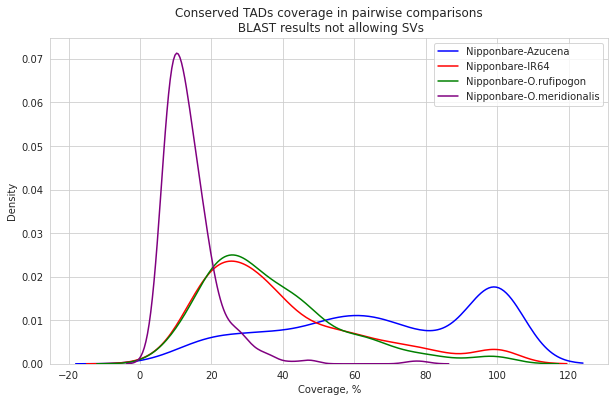

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of file names
file_names = [
    'npb_az_query_cov.txt',
    'npb_ir64_query_cov.txt',
    'npb_oruf_query_cov.txt',
    'npb_omer_query_cov.txt'
]

# List of color names
colors = ['blue', 'red', 'green', 'purple']

# List of custom legend labels
labels = ['Nipponbare-Azucena', 'Nipponbare-IR64', 'Nipponbare-O.rufipogon', 'Nipponbare-O.meridionalis']

# Set the style for the plot
sns.set_style("whitegrid")

# Create subplots to plot all KDE plots on the same graph
fig, ax = plt.subplots(figsize=(10,6))

# Loop through each file and plot KDE with custom color and label
for file_name, color, label in zip(file_names, colors, labels):
    # Read the data from the file
    data = pd.read_csv(file_name, sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])
    
    # Filter the data to keep only rows with 'TAD' in col6
    tad_data = data[data['col6'] == 'TAD']
    
    # Create a KDE plot for column 2 in the 'TAD' data with custom color and label
    sns.kdeplot(data=tad_data, x='col2', ax=ax, color=color, label=label)

# Add labels and a legend
plt.xlabel('Coverage, %')
plt.title('Conserved TADs coverage in pairwise comparisons\n BLAST results not allowing SVs')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

# Identifying TADs conserved between NPB-az-IR64 (O.sativa-specific)
Take rows from npb_az_query_cov.txt and npb_ir64_query_cov.txt with 'TAD' in col6<br>
Any query_coverage counts

In [18]:
import pandas as pd

# Read data from npb_az_query_cov.txt and npb_ir64_query_cov.txt
az_data = pd.read_csv('npb_az_query_cov.txt', sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])
ir64_data = pd.read_csv('npb_ir64_query_cov.txt', sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])

# Filter rows with 'TAD' in col6 in both DataFrames
filtered_az = az_data[(az_data['col6'] == 'TAD')]
filtered_ir64 = ir64_data[(ir64_data['col6'] == 'TAD')]

# Merge the filtered DataFrames on col1
merged_data = pd.merge(filtered_az, filtered_ir64, on='col1', how='inner')

# Create the new DataFrame with selected columns
result = merged_data[['col1', 'col2_x', 'col2_y', 'col6_x']]

# Rename the columns
result.columns = ['col1', 'col2', 'col3', 'col4']

# Write the result to a new file
result.to_csv('NPB-az-ir64.txt', sep='\t', header=False, index=False)

!wc -l NPB-az-ir64.txt

291 NPB-az-ir64.txt


In [ ]:
NPB-az-ir64.txt file structure:
    col1 - TAD coordinates in NPB
    col2 - query coverage of NPB TAD by the azucena sequence (blast-based)
    col3 - query coverage of NPB TAD by the ir64 sequence (blast-based)
    col4 - TAD

# Identifying TADs conserved between NPB-az-oruf
Any query_coverage counts

In [19]:
import pandas as pd

# Read data from npb_az_query_cov.txt and npb_ir64_query_cov.txt
az_data = pd.read_csv('npb_az_query_cov.txt', sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])
ir64_data = pd.read_csv('npb_oruf_query_cov.txt', sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])

# Filter rows with 'TAD' in col6 in both DataFrames
filtered_az = az_data[(az_data['col6'] == 'TAD')]
filtered_ir64 = ir64_data[(ir64_data['col6'] == 'TAD')]

# Merge the filtered DataFrames on col1
merged_data = pd.merge(filtered_az, filtered_ir64, on='col1', how='inner')

# Create the new DataFrame with selected columns
result = merged_data[['col1', 'col2_x', 'col2_y', 'col6_x']]

# Rename the columns
result.columns = ['col1', 'col2', 'col3', 'col4']

# Write the result to a new file
result.to_csv('NPB-az-oruf.txt', sep='\t', header=False, index=False)

!wc -l NPB-az-oruf.txt

280 NPB-az-oruf.txt


In [ ]:
NPB-az-ir64.txt file structure:
    col1 - TAD coordinates in NPB
    col2 - query coverage of NPB TAD by the azucena sequence (blast-based)
    col3 - query coverage of NPB TAD by the oruf sequence (blast-based)
    col4 - TAD

# Identifying TADs conserved between NPB-az-oruf-IR64
Any query_coverage counts

In [21]:
import pandas as pd

# Read data from npb_az_query_cov.txt and npb_ir64_query_cov.txt
az_data = pd.read_csv('NPB-az-oruf.txt', sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4'])
ir64_data = pd.read_csv('npb_ir64_query_cov.txt', sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])

# Filter rows with 'TAD' in col6 in both DataFrames
filtered_az = az_data[(az_data['col4'] == 'TAD')]
filtered_ir64 = ir64_data[(ir64_data['col6'] == 'TAD')]

# Merge the filtered DataFrames on col1
merged_data = pd.merge(filtered_az, filtered_ir64, on='col1', how='inner')

# Create the new DataFrame with selected columns
result = merged_data[['col1', 'col2_x', 'col3_x', 'col2_y', 'col4_x']]

# Rename the columns
result.columns = ['col1', 'col2', 'col3', 'col4', 'col5']

# Write the result to a new file
result.to_csv('NPB-az-oruf-ir64.txt', sep='\t', header=False, index=False)

!wc -l NPB-az-oruf-ir64.txt

137 NPB-az-oruf-ir64.txt


In [ ]:
NPB-az-ir64.txt file structure:
    col1 - TAD coordinates in NPB
    col2 - query coverage of NPB TAD by the azucena sequence (blast-based)
    col3 - query coverage of NPB TAD by the oruf sequence (blast-based)
    col4 - query coverage of NPB TAD by the ir64 sequence (blast-based)
    col5 - TAD

# Identifying TADs conserved between NPB-az-oruf-IR64-omer
Any query_coverage counts

In [22]:
import pandas as pd

# Read data from npb_az_query_cov.txt and npb_ir64_query_cov.txt
az_data = pd.read_csv('NPB-az-oruf-ir64.txt', sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5'])
ir64_data = pd.read_csv('npb_omer_query_cov.txt', sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])

# Filter rows with 'TAD' in col6 in both DataFrames
filtered_az = az_data[(az_data['col5'] == 'TAD')]
filtered_ir64 = ir64_data[(ir64_data['col6'] == 'TAD')]

# Merge the filtered DataFrames on col1
merged_data = pd.merge(filtered_az, filtered_ir64, on='col1', how='inner')

# Create the new DataFrame with selected columns
result = merged_data[['col1', 'col2_x', 'col3_x', 'col4_x', 'col2_y', 'col5_x']]

# Rename the columns
result.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6']

# Write the result to a new file
result.to_csv('NPB-az-oruf-ir64-omer.txt', sep='\t', header=False, index=False)

!wc -l NPB-az-oruf-ir64-omer.txt

54 NPB-az-oruf-ir64-omer.txt


In [ ]:
#split the col1 into chr,start,end of TAD
with open('NPB-az-oruf-ir64-omer.txt', 'r') as file:
    lines = file.readlines()

# Split each line by ':' and '-' and create three columns separated by tabs
lines = ['\t'.join([part.strip() for part in line.strip().replace('-', ':').split(':')]) for line in lines]

# Sort the lines by the first, second, and third columns
def custom_sort(line):
    cols = line.split('\t')
    col1 = cols[0].strip()
    col1_number = int(col1[3:])  # Extract the numeric part of col1 (e.g., "01" from "chr01")
    return col1_number, col1, cols[1], cols[2]

lines.sort(key=custom_sort)

# Write the sorted content back to the file
with open('NPB-specific.txt', 'w') as file:
    for line in lines:
        file.write(line + '\n')

In [ ]:
NPB-az-ir64.txt file structure:
    col1 - TAD coordinates in NPB
    col2 - query coverage of NPB TAD by the azucena sequence (blast-based)
    col3 - query coverage of NPB TAD by the oruf sequence (blast-based)
    col4 - query coverage of NPB TAD by the ir64 sequence (blast-based)
    col5 - query coverage of NPB TAD by the omer sequence (blast-based)
    col6 - TAD

# Identifying NPB-specific TADs

In [34]:
import pandas as pd

# Define the list of file names
file_names = ['npb_az_query_cov.txt', 'npb_ir64_query_cov.txt', 'npb_oruf_query_cov.txt', 'npb_omer_query_cov.txt']

# Create a dictionary to store DataFrames for each file
data_frames = {}

# Load each file into a DataFrame and store it in the dictionary
for file_name in file_names:
    data_frames[file_name] = pd.read_csv(file_name, sep='\t', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])

# Initialize a set to store common 'col1' values
common_col1_values = None

# Iterate through the DataFrames and find common 'nonTAD' rows
for file_name in file_names:
    current_df = data_frames[file_name]
    nonTAD_rows = current_df[(current_df['col6'] == 'nonTAD')]

    if common_col1_values is None:
        common_col1_values = set(nonTAD_rows['col1'])
    else:
        common_col1_values &= set(nonTAD_rows['col1'])

# Write the common 'nonTAD' col1 values to the output file 'NPB-specific.txt'
with open('NPB-specific.txt', 'w') as output_file:
    for col1_value in common_col1_values:
        output_file.write(f"{col1_value}\n")
!wc -l NPB-specific.txt

296 NPB-specific.txt


In [54]:
#extracting NPB coordinates of TADs from txt files to bed (used same code for other groups)

# Read the content of the original file
with open('npb_az_query_cov.txt', 'r') as file:
    lines = file.readlines()

# Filter and process lines with 'TAD' in the last column
processed_lines = [
    '\t'.join(line.strip().split(':')[:3]).replace('-', '\t')
    for line in lines
    if line.strip().split('\t')[-1] == 'TAD'  # Only process lines with 'TAD' in the last column
]

# Write the processed content to the new file npb-az.bed
with open('npb-az.bed', 'w') as file:
    for line in processed_lines:
        first_three_columns = line.split('\t')[:3]  # Extract only the first three columns
        file.write('\t'.join(first_three_columns) + '\n')

In [8]:
#sorting .bed files
# Read the content of the file into a list of lines
with open('group6.bed', 'r') as file:
    lines = file.readlines()

# Define a custom sort key function
def custom_sort(line):
    parts = line.split('\t')
    col1 = parts[0]
    col2 = int(parts[1])
    col3 = int(parts[2])
    col1_number = int(col1[3:])  # Extract the numeric part of col1 (e.g., "01" from "chr01")
    return (col1_number, col2, col3)

# Sort the lines using the custom sort key function
lines.sort(key=custom_sort)

# Write the sorted content back to the file
with open('group6.bed', 'w') as file:
    for line in lines:
        file.write(line)

# Analyzing characteristics of different groups (.bed files)
    Group 1 = NPB-specific
    Group 2 = NPB-az conserved (Japonica-specific)
        Group 3 = NPB-az-ir64 conserved (O.sativa-specific)
    Group 4 = NPB-az-oruf
    Group 5 = NPB-az-oruf-ir64
    Group 6 = NPB-az-oruf-ir64-omer

##### Filenames
    NPB-specific group1.bed
    npb-az group2.bed
            npb-az-ir64 group3.bed
    npb-az-oruf group4.bed
    npb-az-oruf-ir64 group5.bed
    npb-az-oruf-ir64-omer group6.bed

### Mean TAD length per group
NS

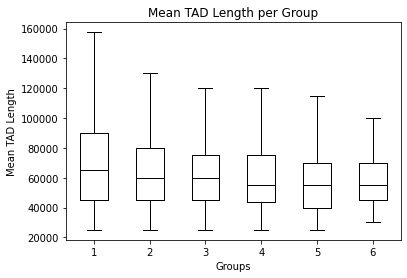

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store TAD lengths for each group
tad_lengths = {}

# Process all five input files
for x in range(1, 7):
    filename = f"group{x}.bed"
    df = pd.read_csv(filename, sep='\t', header=None, names=["chr_tad", "start_tad", "end_tad", "ignore_col"])

    # Calculate TAD lengths for the current group (omit the 'ignore_col' column)
    group_name = f"{x}"
    tad_lengths[group_name] = df["end_tad"] - df["start_tad"]

# Create a list of TAD length values for each group
tad_length_values = list(tad_lengths.values())

# Create vertical boxplots with outliers not shown
plt.boxplot(tad_length_values, vert=True, showfliers=False, medianprops={'color': 'black'})
plt.xlabel("Groups")
plt.xticks(range(1, 7), tad_lengths.keys())
plt.ylabel("Mean TAD Length")
plt.title("Mean TAD Length per Group")
plt.show()

In [1]:
import pandas as pd

# Load the data from the five NPB_TADs_x.bed files (x=1-5)
data = {}
for x in range(1, 7):
    filename = f"group{x}.bed"
    df = pd.read_csv(filename, sep='\t', header=None, names=["chr", "start", "end", "group"])
    data[f"group{x}"] = df

# Calculate the mean TAD length per group
mean_lengths = {}
for x in range(1, 7):
    group_name = f"group{x}"
    mean_length = data[group_name]["end"].mean() - data[group_name]["start"].mean()
    mean_lengths[group_name] = mean_length

print("Mean TAD Lengths:")
for group_name, mean_length in mean_lengths.items():
    print(f"{group_name}: {mean_length:.2f}")

from itertools import combinations
from scipy.stats import ranksums
import statsmodels.stats.multitest as multi

# Perform Wilcoxon rank-sum tests for pairwise group comparisons
p_values = {}
for group1, group2 in combinations(mean_lengths.keys(), 2):
    p_value = ranksums(data[group1]["end"] - data[group1]["start"], data[group2]["end"] - data[group2]["start"]).pvalue
    comparison = f"{group1} vs. {group2}"
    p_values[comparison] = p_value

# Perform multiple comparisons adjustment using Bonferroni correction
adjusted_p_values = multi.multipletests(list(p_values.values()), method='bonferroni')[1]

# Map comparison labels to adjusted p-values
comparison_to_adjusted_p_value = {list(p_values.keys())[i]: adjusted_p_values[i] for i in range(len(p_values))}

# Print the adjusted p-values for pairwise group comparisons
print("Bonferroni-Adjusted P-Values:")
for comparison, adjusted_p_value in comparison_to_adjusted_p_value.items():
    print(f"{comparison}: adjusted p-value = {adjusted_p_value:.4f}")

Mean TAD Lengths:
group1: 74915.54
group2: 66539.37
group3: 63608.25
group4: 61348.21
group5: 59543.80
group6: 58611.11
Bonferroni-Adjusted P-Values:
group1 vs. group2: adjusted p-value = 0.1223
group1 vs. group3: adjusted p-value = 0.0353
group1 vs. group4: adjusted p-value = 0.0016
group1 vs. group5: adjusted p-value = 0.0058
group1 vs. group6: adjusted p-value = 0.0723
group2 vs. group3: adjusted p-value = 1.0000
group2 vs. group4: adjusted p-value = 0.6261
group2 vs. group5: adjusted p-value = 0.6703
group2 vs. group6: adjusted p-value = 1.0000
group3 vs. group4: adjusted p-value = 1.0000
group3 vs. group5: adjusted p-value = 1.0000
group3 vs. group6: adjusted p-value = 1.0000
group4 vs. group5: adjusted p-value = 1.0000
group4 vs. group6: adjusted p-value = 1.0000
group5 vs. group6: adjusted p-value = 1.0000


### Mean gene coverage

In [1]:
#calculate mean gene coverage per tad per group

import pybedtools

# Process all five input files
for x in range(1, 7):
    # Define the paths to your input files
    npb_tads_path = f"group{x}.bed"
    exp_data_path = "../npb_feature_tracks/npb_genes_per_500bp.bedgraph"

    # Load the BED files into BedTool objects and exclude the 4th column
    npb_tads = pybedtools.BedTool(npb_tads_path).cut(range(3))
    exp_data = pybedtools.BedTool(exp_data_path)

    # Use the .map method to calculate the mean expression per TAD
    result = npb_tads.map(exp_data, c=4, o='mean')

    # Create a list to store the results
    results = []

    # Iterate through the result and retrieve the mean expression per TAD
    for interval in result:
        chrom = interval.fields[0]
        start = int(interval.fields[1])
        end = int(interval.fields[2])
        mean_expression = float(interval.fields[3]) if interval.fields[3] != "." else 0.0  # Handle missing values
        results.append((chrom, start, end, mean_expression))

    # Write the results to the te_x.bed file
    output_file = f"genes_{x}.bed"
    with open(output_file, "w") as f:
        for result in results:
            f.write(f"{result[0]}\t{result[1]}\t{result[2]}\t{result[3]}\n")

***** WARNING: File /state/partition1/job-39303177/pybedtools.tbk_ytec.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	350000	385000

***** WARNING: File /state/partition1/job-39303177/pybedtools.tbk_ytec.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	350000	385000

***** WARNING: File /state/partition1/job-39303177/pybedtools.rpk6293d.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1195000	1230000

***** WARNING: File /state/partition1/job-39303177/pybedtools.rpk6293d.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1195000	1230000

***** WARNING: File /state/partition1/job-39303177/pybedtools.pgio8omo.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1195000	1230000

***** WARNING: File /state/partition1/job-39303177/pybedtools.pgio8omo.tmp has a rec

In [1]:
import pandas as pd
from scipy.stats import ranksums
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import itertools

# Load the data from the genes_x.bed files into a DataFrame (one for each x)
data = {}
for x in range(1, 7):
    filename = f"genes_{x}.bed"
    df = pd.read_csv(filename, sep='\t', header=None, names=["chr_tad", "start_tad", "end_tad", "mean_exp_per_tad"])
    data[f"genes_{x}"] = df["mean_exp_per_tad"]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(data["genes_1"], data["genes_2"], data["genes_3"], data["genes_4"], data["genes_5"])

if p_value < 0.05:
    print("There is a significant difference between the groups (te_x.bed files).")

# Initialize an empty list to store group names
group_names = [f"genes_{i}" for i in range(1, 7)]

# Initialize an empty list to store p-values
p_values = []

# Perform Wilcoxon rank sum tests for all pairwise comparisons
for group1, group2 in itertools.combinations(group_names, 2):
    # Perform the Wilcoxon rank sum test
    stat, p = ranksums(data[group1], data[group2])
    p_values.append(p)
    print(f"P-value for {group1} vs. {group2}: {p:.4f}")

# Adjust p-values using the Benjamini-Hochberg procedure
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Print adjusted p-values and significance groups for all pairwise comparisons
print("Adjusted P-values for Pairwise Comparisons:")
for (adjusted_p, (group1, group2)) in zip(adjusted_p_values, itertools.combinations(group_names, 2)):
    comparison = f"{group1} vs. {group2}"
    print(f"{comparison}: Adjusted P-Value={adjusted_p:.4f}")

There is a significant difference between the groups (te_x.bed files).
P-value for genes_1 vs. genes_2: 0.0000
P-value for genes_1 vs. genes_3: 0.0000
P-value for genes_1 vs. genes_4: 0.0000
P-value for genes_1 vs. genes_5: 0.0000
P-value for genes_1 vs. genes_6: 0.0000
P-value for genes_2 vs. genes_3: 0.1273
P-value for genes_2 vs. genes_4: 0.4210
P-value for genes_2 vs. genes_5: 0.0467
P-value for genes_2 vs. genes_6: 0.0316
P-value for genes_3 vs. genes_4: 0.5546
P-value for genes_3 vs. genes_5: 0.4271
P-value for genes_3 vs. genes_6: 0.1653
P-value for genes_4 vs. genes_5: 0.2182
P-value for genes_4 vs. genes_6: 0.0968
P-value for genes_5 vs. genes_6: 0.4463
Adjusted P-values for Pairwise Comparisons:
genes_1 vs. genes_2: Adjusted P-Value=0.0000
genes_1 vs. genes_3: Adjusted P-Value=0.0000
genes_1 vs. genes_4: Adjusted P-Value=0.0000
genes_1 vs. genes_5: Adjusted P-Value=0.0000
genes_1 vs. genes_6: Adjusted P-Value=0.0000
genes_2 vs. genes_3: Adjusted P-Value=0.2121
genes_2 vs. gen

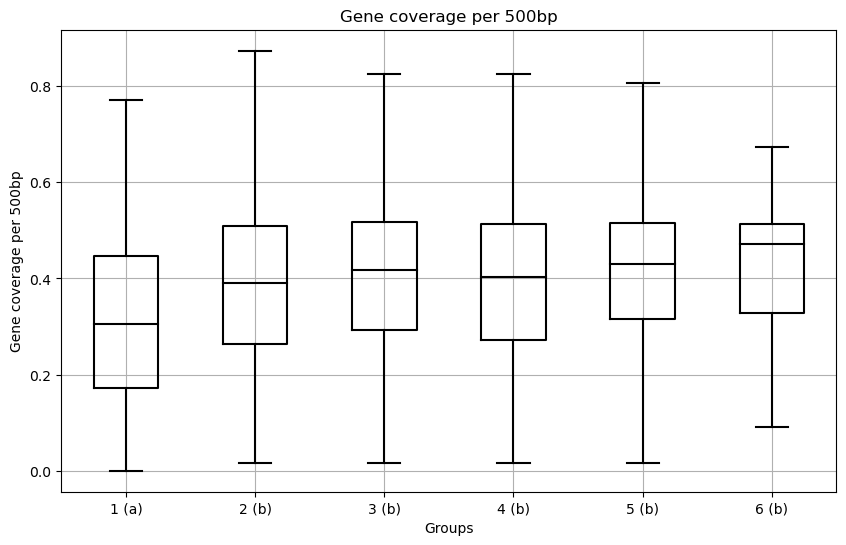

In [2]:
#plot results

import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary to map group names to significance groups
significance_mapping = {
    "1": "a",
    "2": "b",
    "3": "b",
    "4": "b",
    "5": "b",
    "6": "b"
}

# Load the data from your files
data = {}
for group in range(1, 7):
    filename = f"genes_{group}.bed"
    df = pd.read_csv(filename, sep='\t', header=None, names=["chr", "start", "end", "mean_exp"])
    data[f"{group}"] = df["mean_exp"]

# Create a DataFrame with the loaded data
df = pd.DataFrame(data)

# Create a list of group labels with significance groups
group_labels = [f"{group} ({significance_mapping[group]})" for group in df.columns]

# Plot boxplots with group labels
plt.figure(figsize=(10, 6))
boxprops = dict(linewidth=1.5, color="black")
medianprops = dict(linewidth=1.5, color="black")
capprops = dict(linewidth=1.5, color="black")
whiskerprops = dict(linewidth=1.5, color="black")

bp = df.boxplot(column=[f"{i}" for i in range(1, 7)], showfliers=False,
                boxprops=boxprops, medianprops=medianprops,
                capprops=capprops, whiskerprops=whiskerprops)

# Set the x-axis tick labels
plt.xticks(range(1, len(df.columns) + 1), group_labels)

plt.xlabel("Groups")
plt.ylabel("Gene coverage per 500bp")
plt.title("Gene coverage per 500bp")
plt.savefig("genes_groups.png", dpi=300)

plt.show()

### Mean gene expression

In [1]:
#calculate mean te coverage per tad per group

import pybedtools

# Process all five input files
for x in range(1, 7):
    # Define the paths to your input files
    npb_tads_path = f"group{x}.bed"
    exp_data_path = "../expression/Nip_field2017_Normal.bed"

    # Load the BED files into BedTool objects and exclude the 4th column
    npb_tads = pybedtools.BedTool(npb_tads_path).cut(range(3))
    exp_data = pybedtools.BedTool(exp_data_path)

    # Use the .map method to calculate the mean expression per TAD
    result = npb_tads.map(exp_data, c=4, o='mean')

    # Create a list to store the results
    results = []

    # Iterate through the result and retrieve the mean expression per TAD
    for interval in result:
        chrom = interval.fields[0]
        start = int(interval.fields[1])
        end = int(interval.fields[2])
        mean_expression = float(interval.fields[3]) if interval.fields[3] != "." else 0.0  # Handle missing values
        results.append((chrom, start, end, mean_expression))

    # Write the results to the te_x.bed file
    output_file = f"exp_{x}.bed"
    with open(output_file, "w") as f:
        for result in results:
            f.write(f"{result[0]}\t{result[1]}\t{result[2]}\t{result[3]}\n")

***** WARNING: File /state/partition1/job-39303177/pybedtools.orgb66d3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	350000	385000

***** WARNING: File /state/partition1/job-39303177/pybedtools.orgb66d3.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	350000	385000

***** WARNING: File /state/partition1/job-39303177/pybedtools.0hf2g0q2.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1195000	1230000

***** WARNING: File /state/partition1/job-39303177/pybedtools.0hf2g0q2.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1195000	1230000

***** WARNING: File /state/partition1/job-39303177/pybedtools.zb7s7a1a.tmp has a record where naming convention (leading zero) is inconsistent with other files:
chr10	1195000	1230000

***** WARNING: File /state/partition1/job-39303177/pybedtools.zb7s7a1a.tmp has a rec

In [1]:
import pandas as pd
from scipy.stats import ranksums
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import itertools

# Load the data from the genes_x.bed files into a DataFrame (one for each x)
data = {}
for x in range(1, 7):
    filename = f"exp_{x}.bed"
    df = pd.read_csv(filename, sep='\t', header=None, names=["chr_tad", "start_tad", "end_tad", "mean_exp_per_tad"])
    data[f"exp_{x}"] = df["mean_exp_per_tad"]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(data["exp_1"], data["exp_2"], data["exp_3"], data["exp_4"], data["exp_5"])

if p_value < 0.05:
    print("There is a significant difference between the groups (te_x.bed files).")

# Initialize an empty list to store group names
group_names = [f"exp_{i}" for i in range(1, 7)]

# Initialize an empty list to store p-values
p_values = []

# Perform Wilcoxon rank sum tests for all pairwise comparisons
for group1, group2 in itertools.combinations(group_names, 2):
    # Perform the Wilcoxon rank sum test
    stat, p = ranksums(data[group1], data[group2])
    p_values.append(p)
    print(f"P-value for {group1} vs. {group2}: {p:.4f}")

# Adjust p-values using the Benjamini-Hochberg procedure
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Print adjusted p-values and significance groups for all pairwise comparisons
print("Adjusted P-values for Pairwise Comparisons:")
for (adjusted_p, (group1, group2)) in zip(adjusted_p_values, itertools.combinations(group_names, 2)):
    comparison = f"{group1} vs. {group2}"
    print(f"{comparison}: Adjusted P-Value={adjusted_p:.4f}")

P-value for exp_1 vs. exp_2: 0.2132
P-value for exp_1 vs. exp_3: 0.1888
P-value for exp_1 vs. exp_4: 0.0364
P-value for exp_1 vs. exp_5: 0.1257
P-value for exp_1 vs. exp_6: 0.5053
P-value for exp_2 vs. exp_3: 0.7724
P-value for exp_2 vs. exp_4: 0.2163
P-value for exp_2 vs. exp_5: 0.4546
P-value for exp_2 vs. exp_6: 0.9449
P-value for exp_3 vs. exp_4: 0.4173
P-value for exp_3 vs. exp_5: 0.6393
P-value for exp_3 vs. exp_6: 0.9420
P-value for exp_4 vs. exp_5: 0.8671
P-value for exp_4 vs. exp_6: 0.5970
P-value for exp_5 vs. exp_6: 0.6905
Adjusted P-values for Pairwise Comparisons:
exp_1 vs. exp_2: Adjusted P-Value=0.6489
exp_1 vs. exp_3: Adjusted P-Value=0.6489
exp_1 vs. exp_4: Adjusted P-Value=0.5457
exp_1 vs. exp_5: Adjusted P-Value=0.6489
exp_1 vs. exp_6: Adjusted P-Value=0.9416
exp_2 vs. exp_3: Adjusted P-Value=0.9449
exp_2 vs. exp_4: Adjusted P-Value=0.6489
exp_2 vs. exp_5: Adjusted P-Value=0.9416
exp_2 vs. exp_6: Adjusted P-Value=0.9449
exp_3 vs. exp_4: Adjusted P-Value=0.9416
exp_3 

In [2]:
#clustering of samples into significance groups

import pandas as pd
from scipy.stats import ranksums
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import itertools
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# Load the data from the genes_x.bed files into a DataFrame (one for each x)
data = {}
for x in range(1, 7):
    filename = f"exp_{x}.bed"
    df = pd.read_csv(filename, sep='\t', header=None, names=["chr_tad", "start_tad", "end_tad", "mean_exp_per_tad"])
    data[f"exp_{x}"] = df["mean_exp_per_tad"]

# Initialize an empty list to store group names
group_names = [f"exp_{i}" for i in range(1, 7)]

# Initialize an empty list to store p-values
p_values = []

# Perform Wilcoxon rank sum tests for all pairwise comparisons
for group1, group2 in itertools.combinations(group_names, 2):
    # Perform the Wilcoxon rank sum test
    stat, p = ranksums(data[group1], data[group2])
    p_values.append(p)
    print(f"P-value for {group1} vs. {group2}: {p:.4f}")

# Adjust p-values using the Benjamini-Hochberg procedure
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Create a pairwise distance matrix based on adjusted p-values
distance_matrix = np.abs(np.subtract.outer(adjusted_p_values, adjusted_p_values))

# Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='average')

# Determine the number of clusters (significance groups)
num_clusters = 3  # You can adjust the number of clusters as needed

# Perform clustering to classify samples into significance groups
cluster_assignments = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Map cluster assignments to letters (a, b, c, etc.)
cluster_letters = [chr(ord('a') + cluster - 1) for cluster in cluster_assignments]

# Print the classification results
print("Sample Classification:")
for i, group in enumerate(group_names):
    print(f"{group}: {cluster_letters[i]}")

P-value for exp_1 vs. exp_2: 0.2132
P-value for exp_1 vs. exp_3: 0.1888
P-value for exp_1 vs. exp_4: 0.0364
P-value for exp_1 vs. exp_5: 0.1257
P-value for exp_1 vs. exp_6: 0.5053
P-value for exp_2 vs. exp_3: 0.7724
P-value for exp_2 vs. exp_4: 0.2163
P-value for exp_2 vs. exp_5: 0.4546
P-value for exp_2 vs. exp_6: 0.9449
P-value for exp_3 vs. exp_4: 0.4173
P-value for exp_3 vs. exp_5: 0.6393
P-value for exp_3 vs. exp_6: 0.9420
P-value for exp_4 vs. exp_5: 0.8671
P-value for exp_4 vs. exp_6: 0.5970
P-value for exp_5 vs. exp_6: 0.6905
Sample Classification:
exp_1: b
exp_2: b
exp_3: c
exp_4: b
exp_5: a
exp_6: a


<ipython-input-2-1b6bbd8ed040>:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


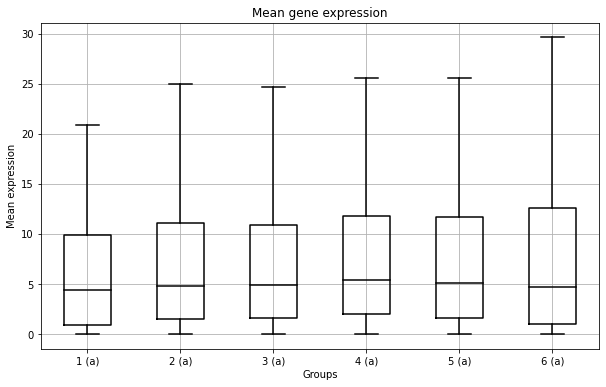

In [4]:
#plot results

import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary to map group names to significance groups
significance_mapping = {
    "1": "a",
    "2": "a",
    "3": "a",
    "4": "a",
    "5": "a",
    "6": "a"
}

# Load the data from your files
data = {}
for group in range(1, 7):
    filename = f"exp_{group}.bed"
    df = pd.read_csv(filename, sep='\t', header=None, names=["chr", "start", "end", "mean_exp"])
    data[f"{group}"] = df["mean_exp"]

# Create a DataFrame with the loaded data
df = pd.DataFrame(data)

# Create a list of group labels with significance groups
group_labels = [f"{group} ({significance_mapping[group]})" for group in df.columns]

# Plot boxplots with group labels
plt.figure(figsize=(10, 6))
boxprops = dict(linewidth=1.5, color="black")
medianprops = dict(linewidth=1.5, color="black")
capprops = dict(linewidth=1.5, color="black")
whiskerprops = dict(linewidth=1.5, color="black")

bp = df.boxplot(column=[f"{i}" for i in range(1, 7)], showfliers=False,
                boxprops=boxprops, medianprops=medianprops,
                capprops=capprops, whiskerprops=whiskerprops)

# Set the x-axis tick labels
plt.xticks(range(1, len(df.columns) + 1), group_labels)

plt.xlabel("Groups")
plt.ylabel("Mean expression")
plt.title("Mean gene expression")
plt.savefig("exp_groups.png", dpi=300)

plt.show()